# Sparse GLMs

One reason we like linear and generalized linear models is that the parameters are readily interpretable. The parameter $\beta_j$ relates changes in covariate $x_j$ to changes in the natural parameter of the response distribution. One common application of such models is for _variable selection_, finding a subset of covariates that are most predictive of the response. To that end, we would like our estimates, $\hat{\mbbeta}$, to be _sparse_. When we have a vast number covariates &mdash; as in genome-wide association studies (GWAS) where we aim to predict a trait given thousands of single nucleotide polymorphisms (SNPs) in the genome &mdash; sparse solutions help focus our attention on the most relevant covariates. 


## Setup

In [1]:
!pip install jaxtyping

In [2]:
import matplotlib.pyplot as plt
import torch

from jaxtyping import Float 
from torch import Tensor
from torch.distributions import Normal, Bernoulli
from typing import Tuple, Optional, Callable

/Users/scott/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lasso Regression

Consider a linear Gaussian model,
\begin{align*}
y_i & \ind{\sim} \mathrm{N}(\beta_0 + \mbx_i^\top \mbbeta, 1)
\end{align*}
for $i = 1, \ldots,n$, where $\beta_0$ is the intercept parameter, $\mbx_i \in \reals^p$ are the covariates, and $\mbbeta \in \reals^p$ are the weights.  We factored out the intercept because we typically don't regularize that parameter.

The Lasso yields sparse solutions for linear models like this by minimizing the (average) negative log likelihood subject to $\ell_1$ regularization. 
\begin{align*}
\cL(\beta_0, \mbbeta) 
&= -\frac{1}{n} \sum_{n=1}^n \log \mathrm{N}(y_i \mid \beta_0 + \mbx_i^\top \mbbeta, 1) + \lambda \|\mbbeta\|_1 \\
&= \frac{1}{2n} \sum_{i=1}^n (y_i - \beta_0 - \mbx_i^\top \mbbeta)^2 + \lambda \|\mbbeta\|_1
\end{align*}
where $\|\mbbeta\|_1 = \sum_{j=1}^p |\beta_j|$. Note that this is a convex objective function! 

It's tempting to just use vanilla gradient ascent to find the optimum,
\begin{align*}
\mbbeta^{(t+1)} &\leftarrow \mbbeta^{(t)} - \alpha_t \nabla \cL(\mbbeta^{(t)}),
\end{align*}
where $\alpha_t \in \reals_+$ is the step size at iteration $t$. 

<!-- 
The $\cO(1/\epsilon)$ convergence rate we discussed for gradient descent in the context of [logistic regression](./03_logreg.md) applied to $L$-smooth functions; i.e., functions that are continuously differentiable with $L$-Lipschitz gradients. (For twice differentiable objective functions, the Lipschitz condition is equivalent to an upper bound on the eigenvalues of the Hessian.)  -->

Unfortunately, the Lasso objective it is not continuously differentiable: the **gradient at $\beta_j=0$ is discontinuous** due to the absolute value in the $\ell_1$ norm. What can we do instead?
- You only live once... run gradient descent and hope for the best!
- Use _subgradient_ descent, taking a step in the direction of any subgradient of $\cL$, but that approach can be much slower, with convergence rates of only $\cO(1/\epsilon^2)$. 
- Use _proximal_ gradient descent, which amounts to _iterative soft thresholding_ for the Lasso problem. This has much better convergence rates, as we'll discuss below. 
- Use _coordinate descent_, which works very well in practice, even if it's harder to prove convergence rates.


## Coordinate Descent

Fix all parameters except for $\beta_j$ for some $j \in \{1,\ldots,p\}$. As a function of $\beta_j$, the average negative log likelihood is,
\begin{align*}
\cL(\beta_j; \mbbeta_{\neg j}) 
&= \frac{1}{2n} \sum_{i=1}^n (\widetilde{y}_{ij} - x_{ij} \beta_j)^2 + \lambda |\beta_j| + c,
\end{align*}
where
\begin{align*}
\widetilde{y}_{ij} &= y_i - \beta_0 - \sum_{k \neq j} x_{ik} \beta_k,
\end{align*}
and where $c$ is constant with respect to $\beta_j$.

This is just a scalar minimization problem. Completing the square, we can rewrite the objective as,
\begin{align*}
\cL(\beta_j; \mbbeta_{\neg j}) 
&= \frac{1}{2} \frac{(\beta_j - \mu_j)^2}{\sigma_j^2} + \lambda |\beta_j| + c'
\end{align*}

::::{admonition} Exercise
Solve for $\mu_j$ and $\sigma_j^2$.

:::{admonition} Answer
:class: tip, dropdown
First, expand the objective as
\begin{align*}
\cL(\beta_j; \mbbeta_{\neg j}) 
&= \frac{1}{2} J_j \beta_j^2 - h_j \beta_j + c
\end{align*}
where
\begin{align*}
J_j &= \frac{1}{n} \sum_{i=1}^n x_{ij}^2 \\
h_j &= \frac{1}{n} \sum_{i=1}^n \widetilde{y}_{ij} x_{ij}.
\end{align*}
Then expand $(\beta_j - \mu_j)^2 / \sigma_j^2$ to see that,
\begin{align*}
\mu_j &= \frac{h_j}{J_j} \\
\sigma_j^2 &= \frac{1}{J_j} \\
\end{align*}
:::
::::


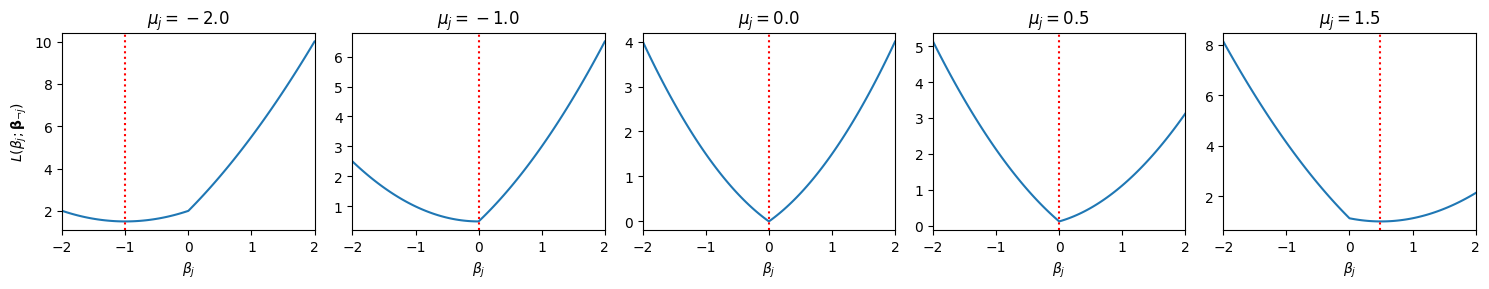

In [3]:
mus = [-2, -1.0, 0.0, 0.5, 1.5]
sigmasq_lmbda = 1.0
betas = torch.linspace(-2, 2, 101)

fig, axs = plt.subplots(1, len(mus), figsize=(3 * len(mus), 3))
for k, (mu, ax) in enumerate(zip(mus, axs)):
    L = 0.5 * (mu - betas)**2 + sigmasq_lmbda * torch.abs(betas)
    ax.plot(betas, L)
    ax.axvline(betas[torch.argmin(L)], color="r", linestyle=":")
    ax.set_title(rf"$\mu_j={mu:.1f}$")
    ax.set_xlabel(r"$\beta_j$")
    ax.set_xlim(-2, 2)
    if k == 0: ax.set_ylabel(r"$L(\beta_j; \mathbf{\beta}_{\neg j})$")
plt.tight_layout()

Note that many of the minimizers (denoted by the red lines) are obtained at $\beta_j = 0$! With a bit of calculus, we can show that the minimizer is given by the **soft-thresholding operator**,
\begin{align*}
\beta_j^\star 
&= \begin{cases}
\mu_j - \sigma_j^2 \lambda & \text{if } \mu_j > \sigma_j^2 \lambda \\
0 &\text{if } |\mu_j| < \sigma_j^2 \lambda \\
\mu_j + \sigma_j^2 \lambda &\text{if } u_j < -\sigma_j^2 \lambda
\end{cases} \\
&\triangleq S_{\sigma_j^2 \lambda}(\mu_j)
\end{align*}

We can write the soft-thresholding operator more compactly as,
\begin{align*}
S_\alpha(\mu) &= \mathrm{sign}(\mu) \max\{|\mu| - \alpha, 0\}.
\end{align*}
Let's plot it below.

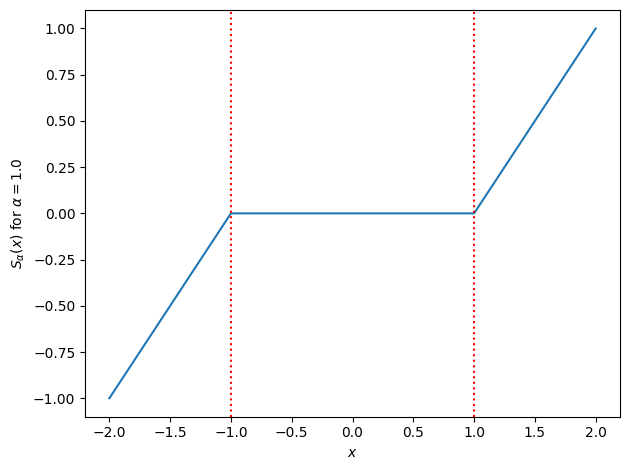

In [4]:
def soft_threshold(x: Float[Tensor, "..."], 
                   alpha: float) \
                   -> Float[Tensor, "..."]:
    """Compute the soft-thresholding operator with argument `x` and threshold `alpha`.
    """
    return torch.sign(x) * torch.maximum(torch.abs(x) - alpha, torch.zeros_like(x))

# Plot the soft-thresholding function
xs = torch.linspace(-2, 2, 101)
alpha = 1.0

plt.plot(xs, soft_threshold(xs, alpha))
plt.xlabel(r"$x$")
plt.ylabel(rf"$S_\alpha(x)$ for $\alpha={alpha:.1f}$")
plt.axvline(alpha, color="r", linestyle=":")
plt.axvline(-alpha, color="r", linestyle=":")
plt.tight_layout()

### Coordinate ascent step for the intercept

:::{admonition} Exercise
:class: tip
Show that the coordinate update for the intercept is,
\begin{align*}
\beta_0^\star &= \frac{1}{n} \sum_{i=1}^n \widetilde{y}_{i0},
\end{align*}
where $\widetilde{y}_{i0} = y_i - \mbx_i^\top \mbbeta$.
:::

### Weighted Lasso Regression

Finally, suppose we have heteroskedastic noise,
\begin{align*}
y_i &\sim \mathrm{N}(\beta_0 + \mbx_i^\top \mbbeta, w_i^{-1})
\end{align*}
where $w_i$ is the inverse variance (precision) of the $i$-th observation. 

Then the objective would become,
\begin{align*}
\cL(\beta_0, \mbbeta) 
&= -\frac{1}{n} \sum_{n=1}^n \log \mathrm{N}(y_i \mid \beta_0 + \mbx_i^\top \mbbeta, w_i^{-1}) + \lambda \|\mbbeta\|_1 \\
&= \frac{1}{2n} \sum_{i=1}^n w_i (y_i - \beta_0 - \mbx_i^\top \mbbeta)^2 + \lambda \|\mbbeta\|_1
\end{align*}
Note that the $w_i$'s become the **weights** in the objective.

Following the same steps as above, we can write the objective as a function of $\beta_j$, 
\begin{align*}
\cL(\beta_j; \mbbeta_{\neg j}) 
&= \frac{1}{2} \frac{(\beta_j - \mu_j)^2}{\sigma_j^2} + \lambda |\beta_j| + c'
\end{align*}
where
\begin{align*}
\mu_j &= \frac{h_j}{J_j} \\
\sigma_j^2 &= \frac{1}{J_j} \\
J_j &= \frac{1}{n} \sum_{i=1}^n w_i x_{ij}^2 \\
h_j &= \frac{1}{n} \sum_{i=1}^n w_i \widetilde{y}_{ij} x_{ij}.
\end{align*}
Again, the coordinate-wise minimum is obtained at $\beta_j^\star = S_{\sigma_j^2 \lambda}(\mu_j)$. 

For the intercept, $\beta_0^\star = \frac{\sum_{i=1}^n w_i \widetilde{y}_{i0}}{\sum_{i=1}^n w_i}$.

### Synthetic Demo

Let's try it out with some synthetic data. We'll simulate data from a model with $p=10$ dimensional covariates and unit-variance Gaussian noise (i.e., all weights are equal to 1). We'll set some of the true weights to be exactly zero and see how well we can recover them from the noisy data.

In [5]:
torch.manual_seed(305 + ord('b'))

n = 100
p = 10
true_beta0 = 0.0
true_beta = Normal(0, 1).sample((p,)) * Bernoulli(0.5).sample((p,))
weights = torch.ones(n)

X = Normal(0, 1).sample((n, p))
y = Normal(X @ true_beta + true_beta0, 1 / weights).sample()

First, let's compare the true weights to the ordinary least squares estimate.

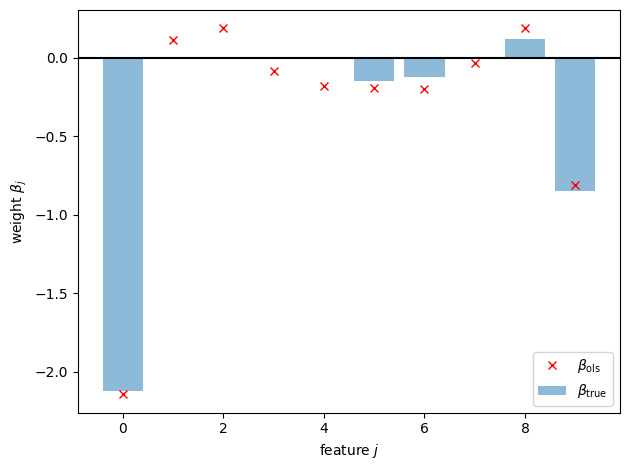

In [6]:
# let's even assume we know beta0 = 0.0 for simplicity
beta_ols = torch.linalg.solve(X.T @ X, X.T @ y)

plt.axhline(0, color="k", linestyle="-")
plt.bar(torch.arange(p), true_beta, alpha=0.5, label=r"$\beta_{\mathsf{true}}$")
plt.plot(torch.arange(p), beta_ols, "rx", label=r"$\beta_{\mathsf{ols}}$")
plt.xlabel(r"feature $j$")
plt.ylabel(r"weight $\beta_j$")
plt.legend()
plt.tight_layout()

Not so good... Let's try with the Lasso, fit using coordinate descent. 

To start, let's just pick $\lambda = 0.1$, for no very good reason.

In [7]:
def coordinate_descent_step(X: Float[Tensor, "num_datapoints num_features"], 
                            y: Float[Tensor, "num_datapoints"], 
                            weights: Float[Tensor, "num_datapoints"], 
                            beta0: Float[Tensor, ""], 
                            beta: Float[Tensor, "num_features"], 
                            lmbda: float) \
                            -> Tuple[Float[Tensor, ""], Float[Tensor, "num_features"]]:
    """
    Perform a single step of coordinate descent for the LASSO problem.
    """
    # Update the intercept
    beta0 = torch.mean(weights * (y - X @ beta)) / torch.mean(weights)
    
    # Update the coefficients
    for j in range(p):
        ytilde_j = y - beta0 - X @ beta + X[:, j] * beta[j]
        sigmasq_j = 1 / torch.mean(weights * X[:, j]**2)
        mu_j = torch.mean(weights * X[:, j] * ytilde_j) * sigmasq_j
        beta[j] = soft_threshold(mu_j, lmbda * sigmasq_j)
    
    return beta0, beta


def weighted_lasso_objective(X: Float[Tensor, "num_datapoints num_features"], 
                             y: Float[Tensor, "num_datapoints"], 
                             weights: Float[Tensor, "num_datapoints"], 
                             beta0: Float[Tensor, ""], 
                             beta: Float[Tensor, "num_features"], 
                             lmbda: float) \
                             -> Float[Tensor, ""]:
    """
    Compute the weighted LASSO objective function.
    """
    return -Normal(X @ beta + beta0, 1 / weights).log_prob(y).mean() + lmbda * torch.norm(beta, 1)


def lasso(X: Float[Tensor, "num_datapoints num_features"], 
          y: Float[Tensor, "num_datapoints"], 
          weights: Optional[Float[Tensor, "num_datapoints"]] = None, 
          beta0: Optional[Float[Tensor, ""]] = None, 
          beta: Optional[Float[Tensor, "num_features"]] = None, 
          lmbda: Optional[float] = 0.,
          loss_fn: Optional[Callable] = lambda *args: torch.nan, 
          num_iter: int = 10) \
          -> Tuple[Float[Tensor, ""], Float[Tensor, "num_features"], Float[Tensor, "num_iter"]]:
    """
    Perform LASSO regression using coordinate descent.
    """
    n, p = X.shape
    
    # Initialize optional parameters
    if weights is None: weights = torch.ones(n)
    if beta0 is None: beta0 = y.mean()
    if beta is None: beta = torch.zeros(p)

    losses = []
    for _ in range(num_iter):
        losses.append(loss_fn(X, y, weights, beta0, beta, lmbda) if loss_fn is not None else None)
        beta0, beta = coordinate_descent_step(X, y, weights, beta0, beta, lmbda)
        
    return beta0, beta, torch.as_tensor(losses)

beta0_lasso, beta_lasso, losses = lasso(X, y, weights, lmbda=0.1, loss_fn=weighted_lasso_objective)

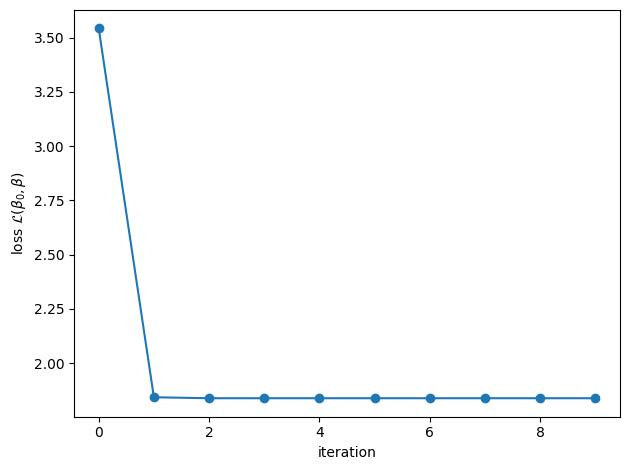

In [8]:
plt.plot(losses, '-o')
plt.xlabel("iteration")
plt.ylabel(r"loss $\mathcal{L}(\beta_0, \beta)$")
plt.tight_layout()

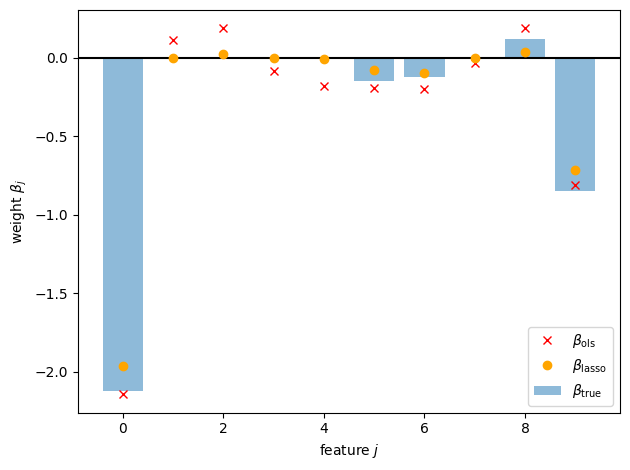

In [9]:
# Now plot the Lasso estimates
plt.axhline(0, color="k", linestyle="-")
plt.bar(torch.arange(p), true_beta, alpha=0.5, label=r"$\beta_{\mathsf{true}}$")
plt.plot(torch.arange(p), beta_ols, "rx", label=r"$\beta_{\mathsf{ols}}$")
plt.plot(torch.arange(p), beta_lasso, "o", color='orange', label=r"$\beta_{\mathsf{lasso}}$")
plt.xlabel(r"feature $j$")
plt.ylabel(r"weight $\beta_j$")
plt.legend()
plt.tight_layout()

:::{admonition} Questions
:class: tip

1. Can you identify two was in which the Lasso estimate differs from the OLS estimate?
2. What estimate do you get if you set $\lambda = 0$?
3. What if you take $\lambda \to \infty$?
:::

## Fitting Sparse GLMs

Now let's generalize this approach to fit $\ell_1$-regularized GLMs! This is exactly what the `glmnet` package {cite:p}`friedman2010regularization` solves. 

Suppose we have a GLM with the canonical mean function, 
\begin{align*}
\E[Y_i] &= f(\beta_0 + \mbx_i^\top \mbbeta)
\end{align*}
where we have again factored out the intercept. 

The regularized objective is,
\begin{align*}
\cL(\beta_0, \mbbeta)
&= -\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid f(\beta_0 + \mbx_i^\top \mbbeta)) + \lambda \|\mbbeta \|_1.
\end{align*}

### Review: Iteratively Reweighted Least Squares
Recall that Newton's method for canonical GLMs (without regularization) is equivalent to **iteratively reweighted least squares**. The $(t+1)$-th step of Newton's method is equivalent to solving a weighted least squares problem to find the minimum of an objective,
\begin{align*}
\widetilde{\cL}(\beta_0, \mbbeta; \beta_0^{(t)}, \mbbeta^{(t)})
&= \frac{1}{n} \sum_{i=1}^n w_i^{(t)} (z_i^{(t)} - \beta_0 - \mbx_i^\top \mbbeta)^2
\end{align*}
where the working responses are
\begin{align*}
z_i^{(t)} = \beta_0^{(t)} + \mbx_i^\top \mbbeta^{(t)} + \frac{y_i - \hat{y}_i^{(t)}}{w_i^{(t)}},
\end{align*} 
the predictions are,
\begin{align*}
\hat{y}_i^{(t)} &= f(\beta_0^{(t)} + \mbx_i^\top \mbbeta^{(t)}),
\end{align*}
and the weights are equal to the conditional variances,
\begin{align*}
w_i^{(t)} &= \mathrm{Var}[Y_i \mid \mbx_i, \beta_0^{(t)}, \mbbeta^{(t)}].
\end{align*}

For example, in a logistic regression, 
\begin{align*}
\hat{y}_i^{(t)} &= \sigma(\beta_0^{(t)} + \mbx_i^\top \mbbeta^{(t)}) \\
w_i &= \hat{y}_i^{(t)} (1 - \hat{y}_i^{(t)}).
\end{align*}

### The Algorithm

From here, we can sketch out a pretty straightforward algorithm for fitting sparse GLMs. Within each Newton iteration, solve a weighted least squares problem, _subject to the $\ell_1$-regularization penalty_, using coordinate descent. Once the coordinate descent procedure converges, update the working responses and weights, then repeat. This is essentially the algorithm in `glmnet` {cite:p}`friedman2010regularization`!

### Synthetic Demo

Let's try it out on some synthetic data, like above. We'll modify the simulation to produce binary responses 

In [10]:
torch.manual_seed(305 + ord('b'))

n = 100
p = 10
true_beta0 = 0.0
true_beta = Normal(0, 1).sample((p,)) * Bernoulli(0.5).sample((p,))

X = Normal(0, 1).sample((n, p))
y = Bernoulli(logits=X @ true_beta + true_beta0).sample()

First, we'll fit the model with maximum likelihood estimation using scikit learn.

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=100.0, fit_intercept=True)
lr.fit(X, y)
beta_mle = torch.tensor(lr.coef_.squeeze(), dtype=torch.float32)

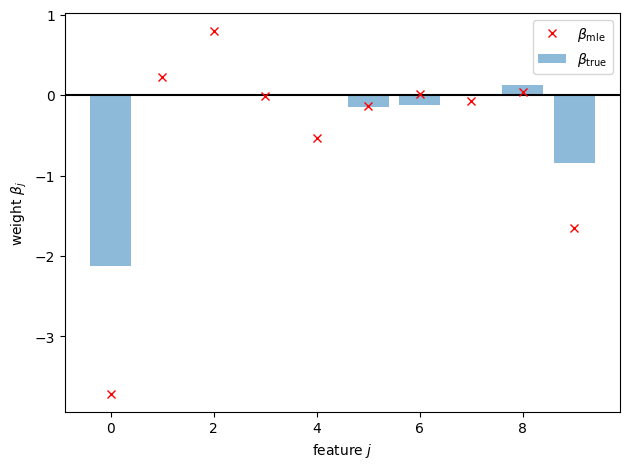

In [12]:
plt.axhline(0, color="k", linestyle="-")
plt.bar(torch.arange(p), true_beta, alpha=0.5, label=r"$\beta_{\mathsf{true}}$")
plt.plot(torch.arange(p), beta_mle, "rx", label=r"$\beta_{\mathsf{mle}}$")
plt.xlabel(r"feature $j$")
plt.ylabel(r"weight $\beta_j$")
plt.legend()
plt.tight_layout()

Now let's implement the `glmnet` algorithm.

In [13]:
def logreg_lasso_objective(X: Float[Tensor, "num_datapoints num_features"], 
                           y: Float[Tensor, "num_datapoints"], 
                           beta0: Float[Tensor, ""], 
                           beta: Float[Tensor, "num_features"], 
                           lmbda: float) \
                           -> Float[Tensor, ""]:
    """
    Compute the logistic regression LASSO objective function
    """
    return -Bernoulli(logits=X @ beta + beta0).log_prob(y).mean() + lmbda * torch.norm(beta, 1)


def _glmnet_step(X: Float[Tensor, "num_datapoints num_features"], 
                 y: Float[Tensor, "num_datapoints"], 
                 beta0: Float[Tensor, ""], 
                 beta: Float[Tensor, "num_features"], 
                 lmbda: float,
                 num_coord_ascent_steps: int=10) \
                 -> Tuple[Float[Tensor, ""], Float[Tensor, "num_features"]]:
    """
    Solve the inner LASSO problem for a single step of the glmnet algorithm.
    """
    # Compute the working responses and weights using the current parameters
    yhat = torch.sigmoid(X @ beta + beta0)
    weights = yhat * (1 - yhat)
    z = X @ beta + beta0 + (y - yhat) / weights
    
    # Solve the weighted lasso problem using the code above to obtain new params
    beta0, beta, _ = lasso(X, z, weights,
                           beta0=beta0,
                           beta=beta,
                           lmbda=lmbda,
                           num_iter=num_coord_ascent_steps)
    
    return beta0, beta

def glmnet(X: Float[Tensor, "num_datapoints num_features"], 
           y: Float[Tensor, "num_datapoints"], 
           beta0: Optional[Float[Tensor, ""]] = None, 
           beta: Optional[Float[Tensor, "num_features"]] = None, 
           lmbda: Optional[float] = 0.,
           num_iter: int = 10, 
           num_coord_ascent_steps: int = 10) \
           -> Tuple[Float[Tensor, ""], Float[Tensor, "num_features"], Float[Tensor, "num_iter"]]:
    """
    Find the MLE of logistic regression with LASSO regularization using the glmnet algorithm.
    """
    n, p = X.shape
    
    # Initialize beta0 and beta
    if beta0 is None: beta0 = torch.logit(y.mean())
    if beta is None: beta = torch.zeros(p)

    losses = []
    for _ in range(num_iter):
        losses.append(logreg_lasso_objective(X, y, beta0, beta, lmbda))
        beta0, beta = _glmnet_step(X, y, beta0, beta, lmbda, num_coord_ascent_steps)
        
    return beta0, beta, torch.as_tensor(losses)

In [14]:
# Run it!
beta0_glmnet, beta_glmnet, losses = glmnet(X, y, lmbda=0.05)

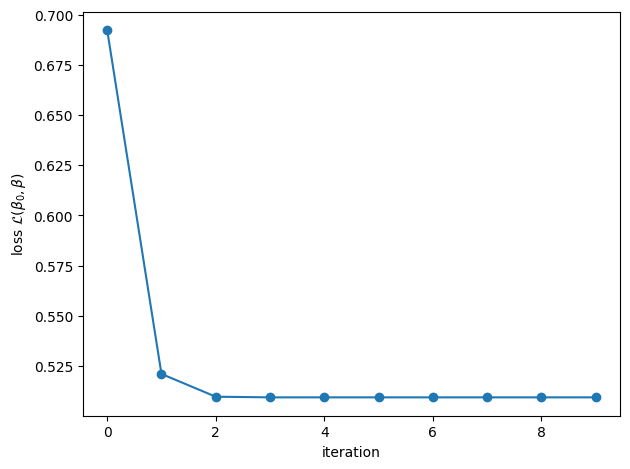

In [15]:
plt.plot(losses, '-o')
plt.xlabel("iteration")
plt.ylabel(r"loss $\mathcal{L}(\beta_0, \beta)$")
plt.tight_layout()

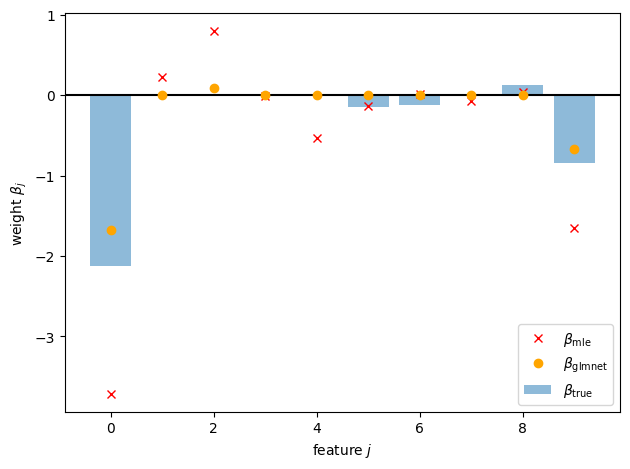

In [16]:
plt.axhline(0, color="k", linestyle="-")
plt.bar(torch.arange(p), true_beta, alpha=0.5, label=r"$\beta_{\mathsf{true}}$")
plt.plot(torch.arange(p), beta_mle, "rx", label=r"$\beta_{\mathsf{mle}}$")
plt.plot(torch.arange(p), beta_glmnet, "o", color="orange", label=r"$\beta_{\mathsf{glmnet}}$")
plt.xlabel(r"feature $j$")
plt.ylabel(r"weight $\beta_j$")
plt.legend()
plt.tight_layout()

### Computational Tricks

Our implementation is far from optimized, and there are several simple tricks to speed it up.
- Rather than recomputing the residual for each coordinate, we can update and downdate the residual after each coordinate update.
- You can show that the coordinate updates only depend on sufficient statistics $\sum_{i} w_i x_{ij} x_{ik}$ and $\sum_i w_i z_i x_{ij}$, and these statistics don't change within the each outer loop. We can save some time by precomputing these at the start of the `_glmnet_step` function. This trick is referred to as using _covariance updates_. 
- When $X$ is sparse, we can implement the sufficient statistics calculations even more efficiently.

{cite:t}`friedman2010regularization` describe several other implementation-level details for making the code as fast as possible. You should also check out James Yang's thesis and his [amazing `adelie` package for LASSO problems](https://github.com/JamesYang007/adelie).

## Proximal Methods

The `glmnet` algorithm is intuitive, but **why the heck does it work?!** To gain a deeper theoretical understanding, let's take a step back and talk about proximal methods.

### Proximal Gradient Descent

Proximal gradient descent is an optimization algorithm for convex objectives that decompose into a differentiable part and a non-differentiable part,
\begin{align*}
\cL(\mbbeta) &= \cL_{\mathsf{d}}(\mbbeta) + \cL_{\mathsf{nd}}(\mbbeta)
\end{align*}
where $\cL_{\mathsf{d}}$ is convex and _differentiable_, whereas $\cL_{\mathsf{nd}}$ is convex but _not differentiable_. 
The idea is to stick as close to vanilla gradient descent as possible, while correcting for the non-differentiable part of the objective. 

If we just had the differentiable part, $\cL_{\mathsf{d}}$, we could perform gradient descent. One way to think about the gradient descent update is as the solution to a quadratic minimization problem,
\begin{align*}
\mbbeta^{(t+1)} &\leftarrow 
\arg \min_{\mbz} \cL_{\mathsf{d}}(\mbbeta^{(t)}) + \nabla \cL_{\mathsf{d}}(\mbbeta^{(t)})^\top (\mbz - \mbbeta^{(t)}) + \frac{1}{2 \alpha_t} \| \mbz - \mbbeta^{(t)}\|_2^2
\end{align*}
We can think of the surrogate problem as a second order approximation of the objective in which the Hessian is replaced with $\frac{1}{\alpha_t} \mbI$. 

_Proximal_ gradient descent follows the same logic, but it keeps the non-differentiable part,
\begin{align*}
\mbbeta^{(t+1)} &\leftarrow 
\arg \min_{\mbz} \cL_{\mathsf{d}}(\mbbeta^{(t)}) + \nabla \cL_{\mathsf{d}}(\mbbeta^{(t)})^\top (\mbz - \mbbeta^{(t)}) + \frac{1}{2 \alpha_t} \| \mbz - \mbbeta^{(t)}\|_2^2 + \cL_{\mathsf{nd}}(\mbbeta^{(t)}) \\
&= \arg \min_{\mbz} \frac{1}{2 \alpha_t} \| \mbz - (\mbbeta^{(t)} - \alpha_t \nabla \cL_{\mathsf{d}}(\mbbeta^{(t)})) \|_2^2 + \cL_{\mathsf{nd}}(\mbz) \\
\end{align*}
The resulting update balances two parts:
1. Stay close to the vanilla gradient descent update, $\mbbeta^{(t)} - \alpha_t \nabla \cL_{\mathsf{d}}(\mbbeta^{(t)})$.
2. Also minimize the non-differentiable part of the objective, $\cL_{\mathsf{nd}}(\mbbeta^{(t)})$.

As a sanity check, note that we recover vanilla gradient descent with $\cL_{\mathsf{nd}}(\mbbeta^{(t)}) = 0$.



### Proximal Mapping
We call the function,
\begin{align}
\mathrm{prox}(\mbu; \alpha_t) 
&= \arg \min_{\mbz} \frac{1}{2 \alpha_t} \| \mbz - \mbu \|_2^2 + \cL_{\mathsf{nd}}(\mbz)
\end{align}
the **proximal mapping**. 

:::{admonition} Notes
:class: tip
- The proximal mapping depends on the form of the non-differentiable part of the objective, even though we have suppressed that in the notation.
- However, it does _not_ depend on the form of the continuous part of the objective.
:::



### Algorithm
With this definition, the proximal gradient descent algorithm is,

```{prf:algorithm} Proximal Gradient Descent
:label: prox_grad

**Input:** Initial parameters $\mbbeta^{(0)}$, proximal mapping $\mathrm{prox}(\cdot; \cdot)$.

- **For** $t=1,\ldots, T$

    - Set $\mbbeta^{(t)} \leftarrow \mathrm{prox}(\mbbeta^{(t-1)} - \alpha_t \nabla \cL_{\mathsf{d}}(\mbbeta^{(t-1)}); \alpha_t)$.

**Return** $\mbbeta^{(T)}$.
```

So far, it's not obvious that this framing is helpful. We still have a potentially challenging optimization problem to solve in computing the proximal mapping. However, for many problems of interest, the proximal mapping has simpled closed solutions.



### Proximal Gradient Descent for Lasso Regression
Consider the Lasso problem. The objective decomposes into convex differentiable and non-differentiable parts,
\begin{align*}
\cL_{\mathsf{d}}(\mbbeta) &= \frac{1}{2} \|\mby - \mbX \mbbeta\|_2^2 \\
\cL_{\mathsf{nd}}(\mbbeta) &= \lambda \|\mbbeta\|_1.
\end{align*}


### Proximal Mapping
The proximal mapping is,
\begin{align*}
\mathrm{prox}(\mbu; \alpha_t) 
&= \arg \min_{\mbz} \frac{1}{2 \alpha_t} \| \mbz - \mbu \|_2^2 + \lambda \|\mbz\|_1 \\
&= \arg \min_{\mbz} \sum_{j=1}^p  \frac{1}{2 \alpha_t} (z_j - u_j)^2 + \lambda |z_j| 
\end{align*}
It separates into optimization problems for each coordinate, and each coordinate has a closed-form solution in terms of the soft-thresholding operator!
\begin{align*}
[\mathrm{prox}(\mbu; \alpha_t)]_j 
&= S_{\alpha_t \lambda}(u_j)
\end{align*}



### Iterative Soft-Thresholding Algorithm
Now let's plug in the gradient of the differentiable part,
\begin{align*}
\nabla \cL_{\mathsf{d}}(\mbbeta) &= \mbX^\top (\mby - \mbX \mbbeta).
\end{align*}
Substituting this into the proximal gradient descent algorithm yields what is sometimes called the **iterative soft-thresholding algorithm (ISTA)**,

```{prf:algorithm} Iterative Soft-Thresholding
:label: ista

**Input:** Initial parameters $\mbbeta^{(0)}$, covariates $\mbX \in \reals^{n \times p}$, responses $\mby \in \reals^n$

- **For** $t=1,\ldots, T$

    - Set $\mbbeta^{(t)} \leftarrow S_{\alpha_t \lambda}(\mbbeta^{(t-1)} - \alpha_t \mbX^\top (\mby - \mbX \mbbeta^{(t-1)}))$.

**Return** $\mbbeta^{(T)}$.
```



### Convergence 
If $\nabla \cL_{\mathsf{d}}$ is $L$-smooth then proximal gradient descent with fixed step size $\alpha_t = 1/L$ then,
\begin{align*}
f(\mbbeta^{(t)}) - f(\mbbeta^\star) \leq \frac{L}{2 t} \|\mbbeta^{(0)} - \mbbeta^\star \|_2^2,
\end{align*}
so it matches the gradient descent convergence rate of $\cO(1/\epsilon)$. (With Nesterov's accelerated gradient techniques, you can speed this up to $\cO(1/\sqrt{\epsilon})$.

<!-- 
:::{admonition} Note about intercepts
:class: warning
Note that we have explicitly separated out the intercept in the objective since we typically don't include that term in the regularizer.
::: -->


### Proximal Newton Method

One great thing about proximal gradient descent is its generality. We could easily apply it to $\ell_1$-regularized GLMs, substituting the gradient of the negative log likelihood, which also has a simple closed form expression. The proximal operator remains the same, and we obtain the same converge rates as gradient descent on standard GLMs.

However, we saw that Newton's method yielded significantly faster convergence rates of $\cO(\log \log \frac{1}{\epsilon})$. Can we obtain similar performance for $\ell_1$-regularized GLMs? 

To obtain a **proximal Newton method**, we proceed in the same fashion as above, but rather than approximating the second order term with $\alpha_t^{-1} \mbI$, we will use the Hessian of $\cL_{\mathsf{d}}$.  That leads to a proximal mapping of the form,
\begin{align*}
\mathrm{prox}(\mbu; \mbH_t) 
&= \arg \min_{\mbz} \frac{1}{2} \| \mbz - \mbu \|_{\mbH_t}^2 + \cL_{\mathsf{nd}}(\mbz)
\end{align*}
where $\|\mbx \|_{\mbH_t}^2 = \mbx^\top \mbH_t \mbx$ is a squared norm induced by the positive definite matrix $\mbH_t$. 

:::{admonition} Note
:class: tip
Note that proximal mapping for proximal gradient descent corresponds to the special case in which $\mbH_t = \frac{1}{\alpha_t} \mbI$. 
:::


Let $\mbg_t = \nabla \cL_{\mathsf{d}}(\mbbeta^{(t)})$ and $\mbH_t = \nabla^2 \cL_{\mathsf{d}}(\mbbeta^{(t)})$ denote the gradient and Hessian, respectively. The _undamped_ proximal Newton update is,
\begin{align*}
\hat{\mbbeta}^{(t+1)}
&\leftarrow \arg \min_{\mbz} \cL_{\mathsf{d}}(\mbbeta^{(t)}) + (\mbz - \mbbeta^{(t)})^\top \mbg_t + \frac{1}{2} (\mbz - \mbbeta^{(t)})^\top \mbH_t (\mbz - \mbbeta^{(t)}) + \cL_{\mathsf{nd}}(z) \\
&= \arg \min_{\mbz} \frac{1}{2} \| \mbz - (\mbbeta^{(t)} -  \mbH_t^{-1} \mbg_t)\|_{\mbH_t}^2 + \cL_{\mathsf{nd}}(\mbz)  \\
&= \mathrm{prox}(\mbbeta^{(t)} -  \mbH_t^{-1} \mbg_t; \mbH_t)
\end{align*}

As with Newton's method, however, we often need to use damped updates,
\begin{align*}
\mbbeta^{(t+1)} &= \mbbeta^{(t)} + \alpha_t (\hat{\mbbeta}^{(t+1)} - \mbbeta^{(t)}),
\end{align*}
with step size $\alpha_t \in [0, 1]$.

The challenge, as we will see below, is that solving the proximal Newton mapping can be more challenging. 



### Proximal Newton for Sparse GLMs

Let's consider the proximal Newton mapping for $\ell_1$-regularized GLMs, like logistic regression. Here, the non-differentiable part of the objective is $\cL_{\mathsf{nd}}(\mbbeta) = \lambda \|\mbbeta\|_1$. Unfortunately, the proximal Newton update no longer has a closed form solution because when we introduce the Hessian, the problem no longer separates across coordinates since the Hessian is generally not diagonal.

However, note that the proximal Newton step minimizes a second-order Taylor approximation of the log likelihood plus an $\ell_1$-regularization penalty,
\begin{align*}
\mathrm{prox}(\mbu; \mbH_t) 
&= \arg \min_{\mbz} \cL_{\mathsf{d}}(\mbbeta^{(t)}) + (\mbz - \mbbeta^{(t)})^\top \mbg_t + \frac{1}{2} (\mbz - \mbbeta^{(t)})^\top \mbH_t (\mbz - \mbbeta^{(t)}) + \cL_{\mathsf{nd}}(z)
\end{align*}

This is exactly the same problem in the inner loop of the `glmnet` algorithm! In particular, we can view the second-order Taylor approximation of the log likelihood as a weighted least squares objective with working responses and weights. We can solve that inner problem with coordinate ascent, just like above. 

**TL;DR: the intuitive algorithm we derived above is really a proximal Newton algorithm.**

### Caveats
As with regular Newton's method, proximal Newton exhibits local quadratic convergence to obtain error $\epsilon$ in $\cO(\log \log 1/\epsilon)$ iterations. Though here, each iteration requires an inner coordinate descent loop to solve the proximal mapping. 

:::{admonition} Note
:class: warning
In practice, you may need to also implement a backtracking line search to choose the step size $\alpha_t$, since you may not start in the local quadratic regime. Logistic regression with decent initialization is reasonably well behaved, but Poisson regression with log link functions can be sensitive. 
:::



## Conclusion

The proximal methods disussed today are what run behind the scenes of modern packages for sparse linear and logistic regression. In particular, [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) uses a fast coordinate descent algorithm like discussed above, and [GLMNet](https://glmnet.stanford.edu/articles/glmnet.html) {cite:p}`friedman2010regularization` uses a proximal Newton algorithm with coordinate descent for the proximal step. 
